### Load the MNIST and CIFAR10 Datasets
- Both datasets will be loaded from the torch.vision python package to make the import easier

In [14]:
# Load the Datasets
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable

# Use GPU as the device if possible
default_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(default_device)

cuda


In [15]:
default_batch_size = 64

In [16]:
# Load MNIST
# MNIST transform to preprocess the data
transform_mnist = transforms.Compose([transforms.ToTensor()])
# TODO - normalize the training and test datasets

# Download and load the training data
trainset_mnist = datasets.MNIST('./data/MNIST_data/', download=True, train=True, transform=transform_mnist)
trainloader_mnist = torch.utils.data.DataLoader(trainset_mnist, batch_size=default_batch_size, shuffle=True)

# Download and load the test data
testset_mnist = datasets.MNIST('./data/MNIST_data/', download=True, train=False, transform=transform_mnist)
testloader_mnist = torch.utils.data.DataLoader(testset_mnist, batch_size=default_batch_size, shuffle=True)

In [17]:
# LOAD CIFAR 10
# Cifar transform to preprocess the data
transform_cifar = transforms.Compose([transforms.ToTensor()])

# Download and load the training data
trainset_cifar = datasets.CIFAR10('./data/CIFAR10_data/', download=True, train=True, transform=transform_cifar)
trainloader_cifar = torch.utils.data.DataLoader(trainset_cifar, batch_size=default_batch_size, shuffle=True)

# Download and load the test data
testset_cifar = datasets.CIFAR10('./data/CIFAR10_data/', download=True, train=False, transform=transform_cifar)
testloader_cifar = torch.utils.data.DataLoader(testset_cifar, batch_size=default_batch_size, shuffle=True)


Files already downloaded and verified
Files already downloaded and verified


In [23]:
# VAE Model Definition
class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, dropout_rate=0.2):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size, device=default_device),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size, device=default_device),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, latent_size * 2, device=default_device)  # x2 for mean and variance
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size, device=default_device),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size, device=default_device),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, input_size, device=default_device),
            nn.Sigmoid()  # Sigmoid activation for pixel values between 0 and 1
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std, device=default_device)
        return mu + eps * std

    def forward(self, x):
        # Encode
        encoding = self.encoder(x)
        mu, log_var = torch.chunk(encoding, 2, dim=1)

        # Reparameterization trick
        z = self.reparameterize(mu, log_var)

        # Decode
        reconstruction = self.decoder(z)

        return reconstruction, mu, log_var


In [6]:
# GAN Model Definition

In [7]:
# WGAN Model Definition

## Train the Models - MNIST
Start training the VAE, GAN and WGAN models with the MNIST dataset.

In [24]:
# MNIST Data Training
input_size = 28 * 28 # Size of MNIST images - 784
hidden_size = 256 # Hidden size for hidden layer
latent_size = 128 # Latent size for latent vector -- trial [2, 64, 128]
learning_rate = 0.001 # Learning rate for the optimizer
num_epochs = 10 # Number of epochs to train for

# Initialize the model
vae_model = VAE(input_size, hidden_size, latent_size)

# Loss function
def loss_function(recon_x, x, mu, log_var):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, input_size), reduction='sum')

    # KL Divergence
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return (BCE, KLD)

# Optimizer
optimizer = optim.Adam(vae_model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for i, data in enumerate(trainloader_mnist, 0):
        inputs, _ = data
        inputs = inputs.view(-1, input_size).to(default_device)
        inputs = Variable(inputs)

        # PyTorch accumulates gradients on subsequent backward passes - so zero the grads
        optimizer.zero_grad()

        # Forward pass
        recon_batch, mu, log_var = vae_model(inputs)

        # Binary cross entropy, KL divergence
        (BCE, KLD) = loss_function(recon_batch, inputs, mu, log_var)
        totalloss = BCE + KLD

        # Backward pass
        totalloss.backward()

        # Update weights
        optimizer.step()

        if i % 500 == 0:
            print('Epoch [{}/{}], Step [{}/{}], BCE: {:.4f}, KLD: {:.4f}, Total Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, len(trainloader_mnist), BCE.item(), KLD.item(), totalloss.item()))


Epoch [1/10], Step [1/938], BCE: 34838.3281, KLD: 20.0837, Loss: 34858.4102
Epoch [1/10], Step [501/938], BCE: 11587.1719, KLD: 374.7930, Loss: 11961.9648
Epoch [2/10], Step [1/938], BCE: 10342.1455, KLD: 610.9353, Loss: 10953.0811
Epoch [2/10], Step [501/938], BCE: 9156.4473, KLD: 785.4516, Loss: 9941.8984


## MNIST Testing Evaluation

Average Reconstruction Loss on Testing Data: 6782.4796


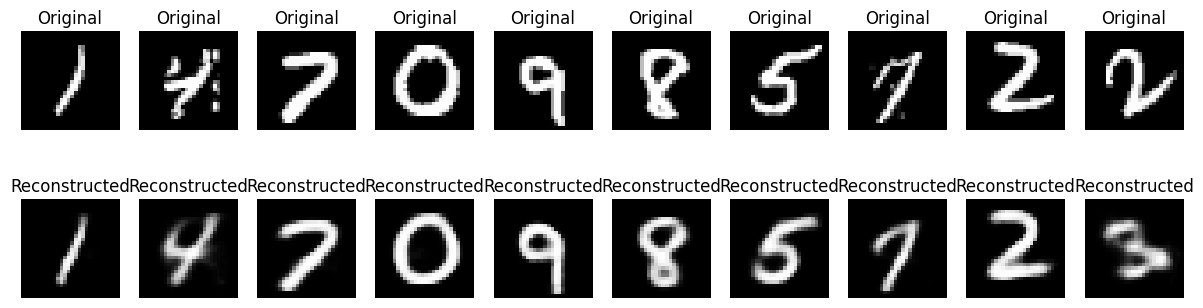

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the training dataset on VAE

vae_model.eval()

# Initialize lists to store original and reconstructed images for testing
test_original_images = []
test_reconstructed_images = []

# Evaluate on the entire testing dataset
with torch.no_grad():
    for data in testloader_mnist:
        inputs, _ = data
        inputs = inputs.view(-1, input_size).to(default_device)
        
        # Forward pass
        recon_batch, _, _ = vae_model(inputs)

        # Convert to numpy arrays for visualization
        test_original_images.append(inputs.cpu().numpy())
        test_reconstructed_images.append(recon_batch.cpu().numpy())

# Concatenate the batches
test_original_images = np.concatenate(test_original_images, axis=0)
test_reconstructed_images = np.concatenate(test_reconstructed_images, axis=0)

# Calculate the average reconstruction loss on the testing dataset
test_average_loss = 0.0
test_num_batches = 0

with torch.no_grad():
    for data in testloader_mnist:
        inputs, _ = data
        inputs = inputs.view(-1, input_size).to(default_device)

        # Forward pass
        recon_batch, mu, log_var = vae_model(inputs)

        # Compute loss
        (BCE, KLD) = loss_function(recon_batch, inputs, mu, log_var)
        loss = BCE + KLD
        test_average_loss += loss.item()
        test_num_batches += 1

test_average_loss /= test_num_batches
print(f'Average Reconstruction Loss on Testing Data: {test_average_loss:.4f}')

# Visualize some original and reconstructed images for testing
n_test_samples = 10
test_indices = np.random.choice(len(test_original_images), n_test_samples, replace=False)

fig, axes = plt.subplots(2, n_test_samples, figsize=(15, 4))

for i, index in enumerate(test_indices):
    axes[0, i].imshow(test_original_images[index].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title('Original')

    axes[1, i].imshow(test_reconstructed_images[index].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title('Reconstructed')

plt.show()
